In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from datetime import datetime


df = pd.read_csv('full2017.csv.zip', compression='zip', low_memory=False)

df.drop('Unnamed: 0', axis=1, inplace=True)

# Intro

In another notebook I explored and visualized loan data from Lending Club's Q4. The purpose of this notebook is to expand upon those learnings and predict loan performance for all of 2017 loan data.

In [2]:
df.head()

,loan_amnt,term,int_rate,monthly_pmt,grade,issue_d,purpose,loan_status,dti,recoveries,...,tax_liens,pub_rec_bankruptcies,addr_state,delinq_2yrs,delinq_amnt,annual_inc,num_tl_90g_dpd_24m,num_tl_30dpd,total_return,roi
0,14000.0,60,12.74,316.69,C,Mar,credit_card,Current,17.48,0.0,...,0.0,0.0,CA,0.0,0.0,40000.0,0.0,0.0,19001.40,135.724286
1,15400.0,60,11.39,337.84,B,Mar,debt_consolidation,Current,11.52,0.0,...,0.0,0.0,CT,0.0,0.0,95000.0,0.0,0.0,20270.40,131.625974
2,4600.0,36,11.39,151.45,B,Mar,credit_card,Current,13.43,0.0,...,0.0,0.0,CT,0.0,0.0,44470.0,0.0,0.0,5452.20,118.526087
3,15000.0,36,5.32,451.73,A,Mar,debt_consolidation,Current,9.35,0.0,...,0.0,0.0,TX,0.0,0.0,182000.0,0.0,0.0,16262.28,108.415200
4,14000.0,36,15.99,492.13,C,Mar,credit_card,Current,31.07,0.0,...,0.0,0.0,KS,0.0,0.0,82000.0,0.0,0.0,17716.68,126.547714


## Feature Engineering

In [3]:
#binarizing the loan status column; 
#1 indicates the loan is performing or paid of 
#0 indicates not performing or defaulted/written off
df.loc[
    (df.loan_status == 'Current') | 
    (df.loan_status == 'Fully Paid') | 
    (df.loan_status =='In Grace Period'), 'loan_status'] = 1 
df.loc[
    (df.loan_status == 'Charged Off') | 
    (df.loan_status == 'Late (31-120 days)') | 
    (df.loan_status =='Default')|
    (df.loan_status == 'Late (16-30 days)'), 'loan_status'] = 0

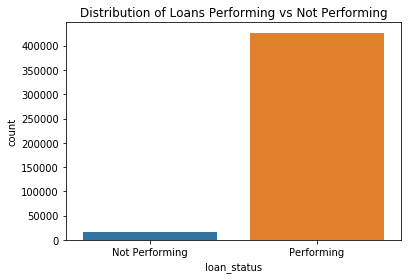

In [4]:
sns.countplot(df.loan_status).set(xticklabels=['Not Performing','Performing'])
plt.title('Distribution of Loans Performing vs Not Performing')
plt.show();

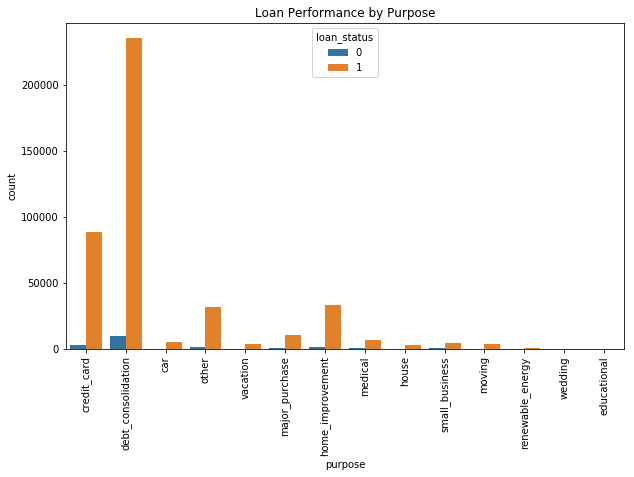

In [5]:
plt.figure(figsize=(10,6))
plt.title('Loan Performance by Purpose')
sns.countplot(df.purpose, hue=df.loan_status)
plt.xticks(rotation=90)
plt.show();

In [6]:
#label encoding loan grades to make the column usable
#label encoding helps keep dimensionality low
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

#let's generate a list of how each var will be encoded
grades = df.grade.unique()
purposes = df.purpose.unique()


grades_encoded = le.fit_transform(grades)
purposes_encoded = le.fit_transform(purposes)

print('Grades: ', grades, '\n')
print('Grades Encoded: ', grades_encoded, '\n')

print('Purposes: ', purposes, '\n')
print('Purposes Encoded: ', purposes_encoded)

Grades:  ['C' 'B' 'A' 'E' 'D' 'G' 'F'] 

Grades Encoded:  [2 1 0 4 3 6 5] 

Purposes:  ['credit_card' 'debt_consolidation' 'car' 'other' 'vacation'
 'major_purchase' 'home_improvement' 'medical' 'house' 'small_business'
 'moving' 'renewable_energy' 'wedding' 'educational'] 

Purposes Encoded:  [ 1  2  0  9 12  6  4  7  5 11  8 10 13  3]


In [7]:
#quick view of the features prior to label encoding
df.loc[:,['grade','issue_d','purpose','addr_state']].head()

,grade,issue_d,purpose,addr_state
0,C,Mar,credit_card,CA
1,B,Mar,debt_consolidation,CT
2,B,Mar,credit_card,CT
3,A,Mar,debt_consolidation,TX
4,C,Mar,credit_card,KS


In [8]:
#label encoding loan grades to make the column usable
#label encoding helps keep dimensionality low
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df['grade'] = le.fit_transform(df.grade)
df['purpose'] = le.fit_transform(df.purpose)
df['addr_state'] = le.fit_transform(df.addr_state)
#df.head()

In [9]:
#value mapping to convert months to their corresponding numerical values
months = {'Jan':1, 'Feb':2,'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
         'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

df['issue_d'] = df.issue_d.map(months)

In [10]:
#quick view of the variables after label encoding and mapping
df.loc[:,['grade','issue_d','purpose','addr_state']].head()

,grade,issue_d,purpose,addr_state
0,2,3,1,4
1,1,3,2,6
2,1,3,1,6
3,0,3,2,42
4,2,3,1,15


In [11]:
df.head()

,loan_amnt,term,int_rate,monthly_pmt,grade,issue_d,purpose,loan_status,dti,recoveries,...,tax_liens,pub_rec_bankruptcies,addr_state,delinq_2yrs,delinq_amnt,annual_inc,num_tl_90g_dpd_24m,num_tl_30dpd,total_return,roi
0,14000.0,60,12.74,316.69,2,3,1,1,17.48,0.0,...,0.0,0.0,4,0.0,0.0,40000.0,0.0,0.0,19001.40,135.724286
1,15400.0,60,11.39,337.84,1,3,2,1,11.52,0.0,...,0.0,0.0,6,0.0,0.0,95000.0,0.0,0.0,20270.40,131.625974
2,4600.0,36,11.39,151.45,1,3,1,1,13.43,0.0,...,0.0,0.0,6,0.0,0.0,44470.0,0.0,0.0,5452.20,118.526087
3,15000.0,36,5.32,451.73,0,3,2,1,9.35,0.0,...,0.0,0.0,42,0.0,0.0,182000.0,0.0,0.0,16262.28,108.415200
4,14000.0,36,15.99,492.13,2,3,1,1,31.07,0.0,...,0.0,0.0,15,0.0,0.0,82000.0,0.0,0.0,17716.68,126.547714


# Models

__KNN Classifier Model__

In [12]:
start_time = datetime.now()

knn = KNeighborsClassifier(n_neighbors=10, weights='distance')

x1= pd.DataFrame({
    'loan_amnt': df.loan_amnt,
    'term': df.term,
    'int_rate': df.int_rate,
    'annual_inc': df.annual_inc,
    'dti': df.dti,
    'grade': df.grade,
    'purpose': df.purpose,
    'addr_state': df.addr_state,
    'issue_d': df.issue_d
    
})
y1= df.loan_status

knn.fit(x1,y1)

y_knn_pred = knn.predict(x1)


print('Accuracy: \n', knn.score(x1,y1))

#test using cross validation
from sklearn.model_selection import cross_val_score

display(cross_val_score(knn, x1,y1, cv=10))
score = cross_val_score(knn, x1, y1, cv=10)
print("KNN Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Accuracy: 
 0.9999977426534657


array([0.96155756, 0.96167043, 0.96142212, 0.96146727, 0.96182844,
       0.96160271, 0.96214447, 0.96223476, 0.96218876, 0.96214361])

KNN Cross Validation Accuracy: 0.962 (+/- 0.001)
Duration: 0:01:31.555309


__BernoulliNB Model__

In [13]:
#using the same features as the KNN model
data = df.loc[:,['loan_amnt','term','int_rate','annual_inc','dti','grade']]
b_target = df.loan_status

In [14]:
start_time = datetime.now()
bnb = BernoulliNB()

bnb.fit(data,b_target)

bnb_pred = bnb.predict(data)

print('Accuracy: ', bnb.score(data,b_target))

score = cross_val_score(bnb, data, b_target, cv=10)
display(score)
print("Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Accuracy:  0.962866649510833


array([0.96286682, 0.96286682, 0.96286682, 0.96286682, 0.96286682,
       0.96286682, 0.96286682, 0.96286682, 0.96286598, 0.96286598])

Cross Validation Accuracy: 0.963 (+/- 0.000)
Duration: 0:00:02.128724


__Random Forest Classification__

In [15]:
# from sklearn.ensemble import RandomForestClassifier; already loaded
start_time = datetime.now()

rfc = RandomForestClassifier()
X_rfc = df.loc[:,['loan_amnt','term','int_rate','annual_inc','dti','grade','purpose']]
Y_rfc= df.loan_status

rfc.fit(X_rfc,Y_rfc)

y_rfc_pred = rfc.predict(X_rfc)

print('Accuracy: ', rfc.score(X_rfc, Y_rfc))

#use cross validation to verify the accuracy
rfc_score = cross_val_score(rfc, X_rfc, Y_rfc, cv=10)
display(rfc_score)
print("RFC Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (rfc_score.mean(), rfc_score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Accuracy:  0.9967087887529966


array([0.95392777, 0.95056433, 0.95977427, 0.95740406, 0.95812641,
       0.96022573, 0.96004515, 0.9614447 , 0.96160184, 0.96121809])

RFC Cross Validation Accuracy: 0.958 (+/- 0.007)
Duration: 0:01:18.643727


__Logistic Regression__

In [16]:
from sklearn.linear_model import LogisticRegression
start_time = datetime.now()

#the class_weight paramater handles class imbalance by assigning weights equal to the inverse
#of the class distribution
lr = LogisticRegression()
w_lr = LogisticRegression(class_weight='balanced')

X = df.loc[:,['loan_amnt','term','int_rate','annual_inc','dti','grade']]
Y = df.loan_status

lr.fit(X,Y)
w_lr.fit(X,Y)

#storing predictions in a variable
lr_pred = lr.predict(X)
w_lr_pred = w_lr.predict(X) 


u_score = cross_val_score(lr, X, Y, cv=10)
print('Unweighted Accuracy: ', lr.score(X,Y))
print("Unweighted, Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (u_score.mean(), u_score.std() * 2))


w_score = cross_val_score(w_lr, X, Y, cv=10)
print('Weighted Accuracy: ', w_lr.score(X,Y))
print('Weighted, Cross Validation Accuracy:  %0.3f (+/- %0.3f)' % (w_score.mean(), w_score.std() * 2))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Unweighted Accuracy:  0.9628689068573673
Unweighted, Cross Validation Accuracy: 0.963 (+/- 0.000)
Weighted Accuracy:  0.681325875060384
Weighted, Cross Validation Accuracy:  0.678 (+/- 0.036)
Duration: 0:00:48.318889


## Model Evaluation

__KNN Classifier__

In [17]:
print("Number of mislabled points: {}".format((y1 != y_knn_pred).sum()))

Number of mislabled points: 1


In [18]:
#check the predictions
knn_table = pd.crosstab(y1, y_knn_pred, margins=True)
print(knn_table, '\n')

tI_errors = knn_table.loc[0.0,1.0] / knn_table.loc['All','All']
tII_errors = knn_table.loc[1.0,0.0] / knn_table.loc['All','All']

specificity = knn_table.loc[0.0,0.0] / (knn_table.loc[0.0,0.0] + knn_table.loc[0.0,1.0])
sensitivity = knn_table.loc[1.0,1.0] / (knn_table.loc[1.0,0.0] + knn_table.loc[1.0,1.0])

print((
    'KNN Performance:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Sensitivty: {} \n'
    'Specificity: {}'
).format(tI_errors, tII_errors, sensitivity, specificity))

col_0            0       1     All
loan_status                       
0            16450       0   16450
1                1  426547  426548
All          16451  426547  442998 

KNN Performance:
Percent Type I errors: 0.0
Percent Type II errors: 2.257346534295866e-06
Sensitivty: 0.9999976555979632 
Specificity: 1.0


__Bernoulli Naive Bayes __

In [19]:
print("Number of mislabled points: {}".format((b_target !=bnb_pred).sum()))

Number of mislabled points: 16450


In [20]:
bnb_table = pd.crosstab(bnb_pred, b_target, margins=True)
display(bnb_table)

loan_status,0,1,All
row_0,,,
1,16450,426548,442998
All,16450,426548,442998


The model always predicts "Performing".

__Random Forest Classifier__

In [21]:
print("Number of mislabled of points: {}".format((Y_rfc !=y_rfc_pred).sum()))

Number of mislabled of points: 1458


In [22]:
#check the error rates
rfc_table = pd.crosstab(Y_rfc, y_rfc_pred, margins=True)
print(rfc_table, '\n')

rfc_tI_errors = rfc_table.loc[0.0,1.0] / rfc_table.loc['All','All']
rfc_tII_errors = rfc_table.loc[1.0,0.0] / rfc_table.loc['All','All']

specificity = rfc_table.loc[0.0,0.0] / (rfc_table.loc[0.0,0.0] + rfc_table.loc[0.0,1.0])
sensitivity = rfc_table.loc[1.0,1.0] / (rfc_table.loc[1.0,0.0] + rfc_table.loc[1.0,1.0])

print((
    'Random Forest:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Sensitivty: {} \n'
    'Specificity: {}'
).format(rfc_tI_errors, rfc_tII_errors, sensitivity, specificity))

col_0            0       1     All
loan_status                       
0            15026    1424   16450
1               34  426514  426548
All          15060  427938  442998 

Random Forest:
Percent Type I errors: 0.0032144614648373132
Percent Type II errors: 7.674978216605944e-05
Sensitivty: 0.9999202903307483 
Specificity: 0.9134346504559271


__Logistic Regression__


Unweighted Model

In [23]:
#unweighted model
#check the error rates
u_logreg_table = pd.crosstab(Y, lr_pred, margins=True)
print(u_logreg_table, '\n')

u_logreg_tI_errors = u_logreg_table.loc[0.0,1.0] / u_logreg_table.loc['All','All']
u_logreg_tII_errors = u_logreg_table.loc[1.0,0.0] / u_logreg_table.loc['All','All']

specificity = u_logreg_table.loc[0.0,0.0] / (u_logreg_table.loc[0.0,0.0] + u_logreg_table.loc[0.0,1.0])
sensitivity = u_logreg_table.loc[1.0,1.0] / (u_logreg_table.loc[1.0,0.0] + u_logreg_table.loc[1.0,1.0])

print((
    'Weighted Logistic Regression Accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Sensitivty: {} \n'
    'Specificity: {}'
).format(u_logreg_tI_errors, u_logreg_tII_errors, sensitivity, specificity))

col_0        0       1     All
loan_status                   
0            1   16449   16450
1            0  426548  426548
All          1  442997  442998 

Weighted Logistic Regression Accuracy:
Percent Type I errors: 0.0371310931426327
Percent Type II errors: 0.0
Sensitivty: 1.0 
Specificity: 6.0790273556231004e-05


Weighted Model

In [24]:
#weighted model
#check the error rates
logreg_table = pd.crosstab(Y, w_lr_pred, margins=True)
print(logreg_table, '\n')

logreg_tI_errors = logreg_table.loc[0.0,1.0] / logreg_table.loc['All','All']
logreg_tII_errors = logreg_table.loc[1.0,0.0] / logreg_table.loc['All','All']

specificity = logreg_table.loc[0.0,0.0] / (logreg_table.loc[0.0,0.0] + logreg_table.loc[0.0,1.0])
sensitivity = logreg_table.loc[1.0,1.0] / (logreg_table.loc[1.0,0.0] + logreg_table.loc[1.0,1.0])

print((
    'Weighted Logistic Regression Accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Sensitivty: {} \n'
    'Specificity: {}'
).format(logreg_tI_errors, logreg_tII_errors, sensitivity, specificity))

col_0             0       1     All
loan_status                        
0              9944    6506   16450
1            134666  291882  426548
All          144610  298388  442998 

Weighted Logistic Regression Accuracy:
Percent Type I errors: 0.014686296552128903
Percent Type II errors: 0.30398782838748706
Sensitivty: 0.6842887553100706 
Specificity: 0.6044984802431611
